$$\require{mhchem}$$

# Adiabatic flame temperature notebook.

## Extension: detailed calculations, using interpolation of $h_k$ via JANAF tables.

Here, we will extend the initial JANAF table demonstration by interpolating the JANAF table species enthalpy values to locate the temperature where $h_{\rm mix, 2} = h_{\rm mix, 1}$.

To do this, we will use some slightly more advanced coding, where we import an interpolation function from an external library (the popular [SciPy](https://scipy.org/)) to create a lookup function for us.  We will also use the [NumPy](https://numpy.org/) library to handle matrix mathematics for us.  Lastly, we will import [Matplotlib](https://matplotlib.org) to handle some basic plotting.

### Import libraries
Begin by importing the necessary external libraries and functions. The `import XX as YY` syntax gives us an alias for each library.

In [11]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import brentq, newton

%matplotlib inline
import matplotlib.pyplot as plt

### Load the JANAF Tables

JANAF (Joint Army Navy Air Force) tables are a standardized data format for species and can be downloaded from [janaf.nist.gov](https://janaf.nist.gov/).

JANAF files start with two header lines indicating the species and the data in the columns. The following rows contain the actual data and the columns are separated by tab characters.

```text
Methane (CH4)	C1H4(g)
T(K)	Cp	S	-[G-H(Tr)]/T	H-H(Tr)	delta-f H	delta-f G	log Kf
0	0.	0.	INFINITE	-10.024	-66.911	-66.911	INFINITE
100	33.258	149.500	216.485	-6.698	-69.644	-64.353	33.615
...
```


The NumPy `loadtxt()` function reads and loads these data files as NumPy arrays. NumPy does not know how to handle the `INFINITE` data, and we aren't interested in data at 0 K anyways, so we need to skip reading the first three rows of the data. The `skiprows` argument tells NumPy to skip the number of rows in the data file that you pass.

In [2]:
ch4_data = np.loadtxt("data/ch4_janaf.txt", skiprows=3)
o2_data = np.loadtxt("data/o2_janaf.txt", skiprows=3)
co2_data = np.loadtxt("data/co2_janaf.txt", skiprows=3)
h2o_data = np.loadtxt("data/h2o_janaf.txt", skiprows=3)
n2_data = np.loadtxt("data/n2_janaf.txt", skiprows=3)

### Determine the Heats of Formation

To calculate the adiabatic flame temperature, we need the enthalpy of formation and the sensible enthalpy for each species. The enthalpy of formation is in the 6th column of the JANAF table. We need the enthalpy of formation at the reference temperature, 298.15 K. This reference temperature is very common, so the JANAF tables include data at this specific temperature.

By inspecting the tables, we see that the 298.15 K row is the 4th row in the $\ce{CH4}$, $\ce{O2}$, and $\ce{N2}$ tables, and the 3rd row in the $\ce{CO2}$ and $\ce{H2O}$ tables.

NumPy and Python start counting all indices at 0 and they use square brackets for indexing. The variable `data[0]` therefore corresponds to the first item in the vector `data`, `data[1]` the second item, and so on. The heat of formation at 298.15 K is therefore at index `[3, 5]` or `[2, 5]`.

In [3]:
ch4_h_f = ch4_data[3, 5]
o2_h_f = o2_data[3, 5]
n2_h_f = n2_data[3, 5]
co2_h_f = co2_data[2, 5]
h2o_h_f = h2o_data[2, 5]

print(f"{ch4_h_f=}", f"{o2_h_f=}", f"{n2_h_f=}", f"{co2_h_f=}", f"{h2o_h_f=}", sep="\n")

ch4_h_f=-74.873
o2_h_f=0.0
n2_h_f=0.0
co2_h_f=-393.522
h2o_h_f=-241.826


### Create Interpolation Functions

The JANAF tables give us molar enthalpies at discrete temperature values, which may or may not correspond to the adiabatic flame temperatrure of interest. The SciPy library includes a function that computes interpolated values to given data called [`interp1d()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) for 1-dimensional data.

The first column for each data file is the temperature in K and the 5th column is the sensible enthalpy relative to the reference temperature. Thus, we do not need to subtract $h_k \left(298\,\text{K}\right)$ in order to find $q_{\text{heating}}$!

In Python, the colon (`:`) indicates that all of the values in that dimension should be used.

In [4]:
ch4_h_T = interp1d(ch4_data[:, 0], ch4_data[:, 4])
o2_h_T = interp1d(o2_data[:, 0], o2_data[:, 4])
n2_h_T = interp1d(n2_data[:, 0], n2_data[:, 4])
co2_h_T = interp1d(co2_data[:, 0], co2_data[:, 4])
h2o_h_T = interp1d(h2o_data[:, 0], h2o_data[:, 4])

These functions are now callable, as a function of temperature.  We can loop through a range of temperatures and create a more densely populated table of species enthalpies. To demonstrate, let's plot the sensible enthalpy of $\ce{CO2}$ as a function of temperature betwen 300 K and 6000 K, and shows that it accurately reproduces the JANAF data:

<IPython.core.display.Javascript object>


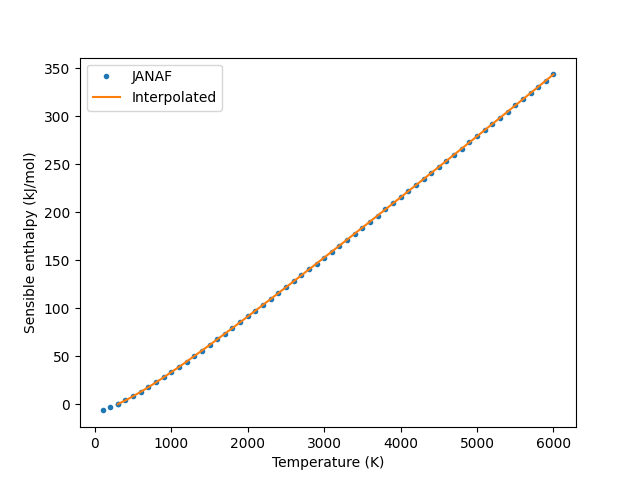

In [5]:
temperatures = np.linspace(300, 6000, 100)
h_co2 = co2_h_T(temperatures)

fig, ax = plt.subplots()

ax.plot(co2_data[:, 0], co2_data[:, 4], "o", markersize=3, label="JANAF")
ax.plot(temperatures, h_co2, label="Interpolated")
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Sensible enthalpy (kJ/mol)")
ax.legend();

As we can see, the interpolation function provides an accurate represntation of the tabulated data.

Now, let's calculate the heat released by the reaction.

In [6]:
q_rxn = 2 * h2o_h_f + co2_h_f - ch4_h_f - 2 * o2_h_f - 2 * 3.76 * n2_h_f

print(f"Heat of combustion = {q_rxn:.2f} kJ/mol.")

Heat of combustion = -802.30 kJ/mol.


This energy is stored as sensible enthalpy of the products, heating the products to a higher temperature. We need to find the temperature at which the enthalpy of the products, relative to their enthalpy at the initial temperature, equals the heat of the reaction.

Now we need to find the temperature at which the enthalpy of the products is equal to the heat of combustion. To find an initial guess, we can plot the enthalpy of the products as a function of temperature.

<IPython.core.display.Javascript object>


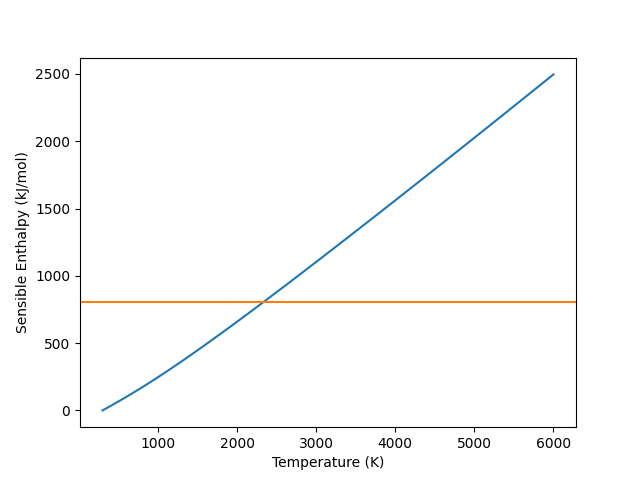

In [7]:
def h_products(T):
    return 2 * h2o_h_T(T) + co2_h_T(T) + 2 * 3.76 * n2_h_T(T)

fig_2, ax_2 = plt.subplots()

ax_2.plot(temperatures, h_products(temperatures))
ax_2.axhline(-q_rxn, color="C1")
ax_2.set_ylabel("Sensible Enthalpy (kJ/mol)")
ax_2.set_xlabel("Temperature (K)");

The intersection point is between 2,300 K and 2,400 K, which we can confirm by printing the values.

In [8]:
print(h_products(2300), h_products(2400), sep="\n")

790.3044
834.4738


To find a more precise value of the temperature, we need to find the root of the function:

$$q_{\text{heating}} + q_{\text{rxn}} = 0$$

SciPy also includes a number of root finding algorithms. Since this is a well-behaved function, a simple Newton-Raphson solver will be sufficient. This is found in the [`newton()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton) function, which takes the function to solve and an initial guess as arguments.

In [19]:
def adiabatic_temperature(T):
    return h_products(T) + q_rxn

T_ad = newton(adiabatic_temperature, 2300)
print(f"The adiabatic flame temperature is T_ad = {T_ad:.2f} K")

The adiabatic flame temperature is T_ad = 2327.16 K


One advantage of this method is that it scales to work with a range of stoichiometry of the original reaction. For the reaction of methane, the equivalence ratio is twice the inverse of the stoichiometric number for oxygen. For complete combustion and fuel lean equivalence ratios, the additional oxygen is present as a product:

$$\ce{CH4 + $\frac{2}{\phi}$(O2 + $3.76$ N2) -> CO2 + 2 H2O + $\frac{7.52}{\phi}$ N2 + $\frac{2}{\phi}\left(1-\phi\right)$ O2}$$

The `newton()` function allows us to pass an array of additional arguments to the function and solve for multiple values simultaneously.

<IPython.core.display.Javascript object>


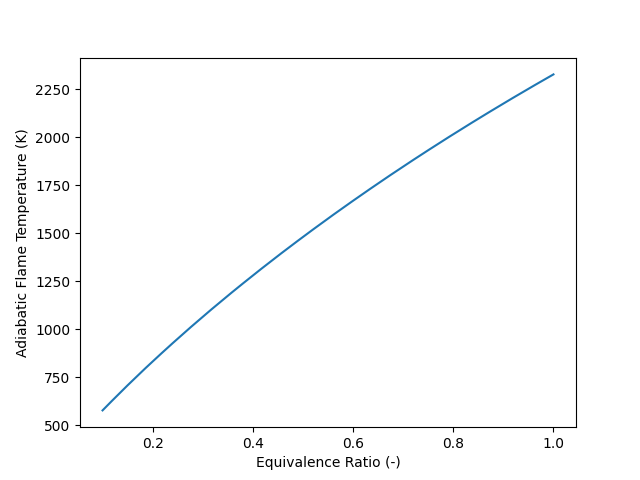

In [22]:
phis = np.linspace(0.1, 1.0, 200)
T_guess = np.ones_like(phis) * 1000.0

def ad_temp_vec(T, phis):
    h_products = 2 * h2o_h_T(T) + co2_h_T(T) + 7.52 / phis * n2_h_T(T) + 2 / phis * (1 - phis) * o2_h_T(T)
    return h_products + q_rxn

T_ads = newton(ad_temp_vec, T_guess, args=(phis,))

fig_3, ax_3 = plt.subplots()
ax_3.plot(phis, T_ads)
ax_3.set_xlabel("Equivalence Ratio (-)")
ax_3.set_ylabel("Adiabatic Flame Temperature (K)");